# Create Training Data

This notebook is modified from Programming Historian lesson. The high-level purpose is to take a pickled array of htids and discover all the pages marked with IMAGE_ON_PAGE, returning a dict.

Then I do some work to get a random sample of illustrated pages, for use in training CNN models.

In [1]:
import json
import matplotlib.pyplot as plt
import os
import pickle
from random import sample, seed
import time

In [2]:
# Import the HT Data API wrapper and non-versioned keys
from hathitrust_api import DataAPI
from keys import ht_keys

# Replace placeholder strings with your HT credentials (leaving the quote marks)
ht_access_key = ht_keys['access']
ht_secret_key = ht_keys['secret']

# instantiate the Data API connection object
data_api = DataAPI(ht_access_key, ht_secret_key)

In [15]:
# file generated by sample_from_ids.py
sample_path = "sample_ids_1800_1850.pkl"

# we want to get all the image page candidates for the volumes in vol_ids
with open(sample_path, "rb") as fp:
    vol_ids = pickle.load(fp)

In [79]:
# sanitize the id for the training data (can always get it back)
def sanitize_id(unsafe_id):
    """htids contain impermissible characters that can't be used as directory names. Mapping gets rid of colon, forward slash, and period
    ':' --> '+'
    '/' --> '='
    Following: https://github.com/dbamman/jcdl2017/blob/master/data/fiction.txt
    """
    safe_id = unsafe_id.replace(":","+")
    safe_id = safe_id.replace("/","=")
    return safe_id


def unsanitize_id(safe_id):
    """gives back the original HT id"""
    original_id = safe_id.replace('+', ':')
    original_id = original_id.replace('=', '/')
    return original_id

In [80]:
def ht_tuple_download(page_tuples, out_dir=None):
    """
    :param page_tuples: array of (htid, page_num) pairs
    :param out_dir: destination for images; if None, no download
    
    Note: if supplied, out_dir must be an existing directory and
    the caller must have write permissions in that directory
    
    :rtype True on success, False on failure
    """
    
    # if out_dir is not None, then also download page images
    if out_dir:
        
        total_pages = len(page_tuples)
        
        for i, pair in enumerate(page_tuples):
            
            item_id, page = pair[0], pair[1]
            safe_id= sanitize_id(item_id)
            
            try:
                # simple status message
                print("[{}] Downloading page {} ({}/{})".format(item_id, page, i+1, total_pages))
                
                img = data_api.getpageimage(item_id, page)
                img_name = safe_id + "_" + str(page) + ".jpg"               
                img_out = os.path.join(out_dir, img_name)
                
                # skip completed downloads
                if os.path.isfile(img_out):
                    continue
                
                with open(img_out, 'wb') as fp:
                    fp.write(img)

                time.sleep(2)

            except Exception as e:
                print("[{}] Error downloading page {}: {}".format(item_id, page, e))
                
    # return True on success
    return True

In [17]:
def ht_picture_locate(item_id):
    """
    :param item_id: unique HathiTrust volume identifier
    
    :rtype list of all IMAGE_ON_PAGE candidates for item_id
    """
    
    # metadata from API in json format (different than HT collection metadata)
    meta = json.loads(data_api.getmeta(item_id, json=True))

    # sequence gets us each page of the PDF in order, with any
    # additional information that might be available for it
    sequence = meta['htd:seqmap'][0]['htd:seq']

    # list of pages with pictures (empty to start)
    img_pages = []

    # try/except block handles situation where no "pfeats" exist OR
    # the sequence numbers are not numeric
    for page in sequence:
        try:
            if 'IMAGE_ON_PAGE' in page['htd:pfeat']:
                img_pages.append(int(page['pseq']))
        except (KeyError, TypeError) as e:
            continue
        
    # track for download progress report
    total_pages = len(img_pages)
                
    # return the list of image pages
    return img_pages

In [23]:
# Dictionary that maps ids to list of page candidates
pdict = {}
count = 0
total = len(vol_ids)

for item_id in vol_ids:
    pdict[item_id] = ht_picture_locate(item_id)
    
    # don't max out the API
    count += 1
    time.sleep(2)
    
    # occasional update
    if count % 20 == 0:
        print("{}/{}".format(count,total))    

20/2401
40/2401
60/2401
80/2401
100/2401
120/2401
140/2401
160/2401
180/2401
200/2401
220/2401
240/2401
260/2401
280/2401
300/2401
320/2401
340/2401
360/2401
380/2401
400/2401
420/2401
440/2401
460/2401
480/2401
500/2401
520/2401
540/2401
560/2401
580/2401
600/2401
620/2401
640/2401
660/2401
680/2401
700/2401
720/2401
740/2401
760/2401
780/2401
800/2401
820/2401
840/2401
860/2401
880/2401
900/2401
920/2401
940/2401
960/2401
980/2401
1000/2401
1020/2401
1040/2401
1060/2401
1080/2401
1100/2401
1120/2401
1140/2401
1160/2401
1180/2401
1200/2401
1220/2401
1240/2401
1260/2401
1280/2401
1300/2401
1320/2401
1340/2401
1360/2401
1380/2401
1400/2401
1420/2401
1440/2401
1460/2401
1480/2401
1500/2401
1520/2401
1540/2401
1560/2401
1580/2401
1600/2401
1620/2401
1640/2401
1660/2401
1680/2401
1700/2401
1720/2401
1740/2401
1760/2401
1780/2401
1800/2401
1820/2401
1840/2401
1860/2401
1880/2401
1900/2401
1920/2401
1940/2401
1960/2401
1980/2401
2000/2401
2020/2401
2040/2401
2060/2401
2080/2401
2100/2401
212

In [25]:
# test by writing to a file
with open("sample_pages.json", "w") as fp:
    json.dump(pdict, fp, sort_keys=True, indent=4)

(array([708., 557., 236., 111.,  73.,  66.,  35.,  40.,  23.,  27.,  19.,
         19.,  10.,  13.,  12.,  16.,  14.,  13.,  11.,   6.,   5.,   6.,
          4.,   6.,   2.,   2.,   5.,   2.,   3.,   1.,   4.,   4.,   4.,
          4.,   0.,   1.,   0.,   2.,   3.,   5.,   4.,   1.,   1.,   4.,
          0.,   2.,   2.,   0.,   0.,   0.,   0.,   3.,   2.,   0.,   1.,
          0.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.]),
 array([  1.  ,   5.99,  10.98,  15.97,  20.96,  25.95,  30.94,  35.93,
         40.92,  45.91,  50.9 ,  55.89,  60.88,  65.87,  70.86,  75.85,
         80.84,  85.83,  90.82,  95.81, 100.8 , 105.79, 110.78, 115.77,
        120.76, 125.75, 130.74, 135.73, 140.72, 145.71, 150.7 , 155.69,
        160.68, 165.67, 170.66

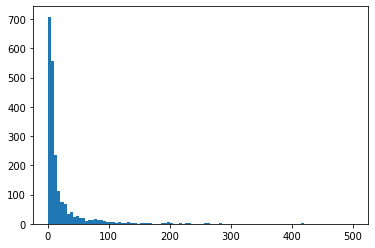

In [42]:
# histogram of number of page candidates per volume
counts = [len(pgs) for pgs in pdict.values()]
plt.hist(counts, bins=100, range=[1,500])

# conlusion: we can sample randomly from this because the heavily-illustrated books don't dominate

In [46]:
# Second stage: randomly sample *pages* from the randomly sampled volumes
all_pages = []
for k,v in pdict.items():
    for p in v:
        all_pages.append((k, p))

In [50]:
N = len(all_pages)

In [51]:
def calculate_sample_size(n):
    # Z table value for 95% confidence interval (normal distribution)
    Z = 1.96
    # probability in population of having attribute (in this case, we could
    # think of half of books being illustrated); assuming 50% gives the
    # maximum variability and is safest assumption
    p = 0.5
    # precision rate of 2%--just using some pretty standard values
    e = 0.02

    # Cochran's formula
    # https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/
    # https://www.checkmarket.com/blog/how-to-estimate-your-population-and-survey-sample-size/
    # https://www.checkmarket.com/sample-size-calculator/
    size = Z**2 * p * (1 - p) / e**2

    # adjust by population size n
    adjusted = size / 1 + ((size - 1) / n)
    return round(adjusted)

In [54]:
n = calculate_sample_size(N)

In [57]:
# always set the same seed!
seed(42)
final_page_sample = sample(all_pages, n)

In [63]:
# save list of tuples of (htid, page_num)
with open("final_page_sample.pkl", "wb") as fp:
    pickle.dump(final_page_sample, fp)

In [1]:
# pass the list of tuples to the function
#ht_tuple_download(final_page_sample, out_dir="training_imgs")